## Plot results for birth death tree

Mamie Wang 2020/10/14



Test run time and accuracy against the length of sequences for birth death tree of size 2000. 

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import seaborn as sns
from matplotlib import cm

import sys, os

sys.path.append("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/spectraltree")

import generation
import reconstruct_tree
import time
import utils
import pandas as pd
import argparse
import dendropy

m   |  mutation rate |  F1 %    |  RF     
----|--------------|----------|------
400 | 0.05         | 89       | 832
800 | 0.01         |   83     | 1290
800 | 0.05         |   94     | 454
800 | 0.1          |   92     | 588
800 | 0.3          |   65     | 2762

In [39]:
# write out list of parameters to run

m = [400, 600, 800, 1000, 1200, 1400, 1600]
tree_type = "birthdeath"
method = ["NJ", "SNJ", "RAxML", 
          "STDR+NJ", "STDR+NJ", "STDR+NJ", 
          "STDR+SNJ", "STDR+SNJ", "STDR+SNJ", 
          "STDR+RAxML", "STDR+RAxML", "STDR+RAxML"]
nrun = 5
size = 2000
path = "None"
threshold = np.tile([0] * 3 + list(np.tile([256, 128, 64], 3)), len(m))
kappa = 2
mutation_rate = 0.05
verbose = True
m_lst = np.repeat(m, len(method))

In [41]:
par_list = pd.DataFrame({"type": tree_type, "method": np.tile(method, len(m)), 
              "nrun": nrun, "size": size, "path": path, "threshold": threshold,  
              "m": m_lst, "kappa": kappa, "mutation_rate": mutation_rate, "verbose": verbose})

In [42]:
par_list.to_csv("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/test_birthdeath_tree.lst", 
                sep = "\t",  index = False)

In [2]:
import glob
import pandas as pd
import re
from matplotlib import cm

def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        perf_metrics.loc[:,"RF"] = perf_metrics.loc[:,"RF"] / (2 * 2000 - 6)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/birthdeath_m*")
metrics, summarized = summarize_perf(paths)
summarized

runtime           RF           F1      
                          mean    std  mean   std   mean   std
m    method                                                   
400  RAxML             2038.34  64.83  0.07  0.00  96.35  0.24
     STDR+RAxML (128)   772.09  20.10  0.12  0.02  94.24  0.82
     STDR+RAxML (256)   744.34  17.83  0.14  0.03  92.84  1.32
     STDR+NJ (128)      318.28   3.37  0.15  0.01  92.69  0.40
     STDR+RAxML (64)    636.49   5.54  0.15  0.02  92.58  0.96
...                        ...    ...   ...   ...    ...   ...
1600 STDR+NJ (64)       291.44  10.12  0.10  0.01  95.05  0.57
     STDR+SNJ (256)     316.99   6.19  0.10  0.00  94.97  0.13
     STDR+SNJ (128)     299.70   3.36  0.11  0.00  94.28  0.13
     STDR+SNJ (64)      444.04  13.36  0.11  0.01  94.55  0.72
     SNJ               1464.42  21.63  0.12  0.00  94.22  0.23

[84 rows x 6 columns]

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


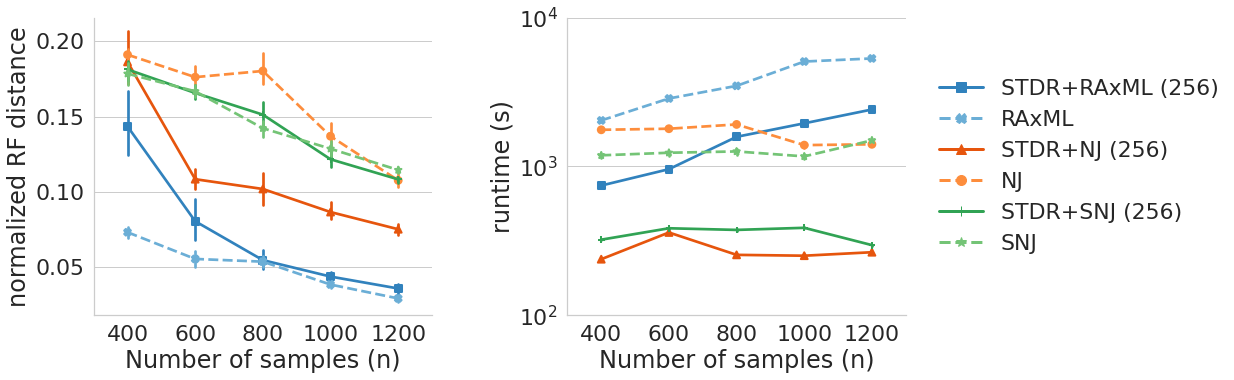

In [4]:
df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (256)", "RAxML", "STDR+NJ (256)","NJ",  "STDR+SNJ (256)", "SNJ"]
markers = ["s", "X", "^", "o", "+", "*"]
linestyles = ["-", "--", "-", "--", "-", "--"]


selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")

df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] 
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

color_subset = [colors[i] for i in [0,1,4,5,8,9]]
color_dict = dict(zip(ordering, np.array(color_subset)))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, 
                markers = markers, 
                linestyles= linestyles, legend = False,
                legend_out = True, gridspec_kws={"wspace":0.4})

labels = ["normalized RF distance", "runtime (s)"]

# adjust ticks and grid lines
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
   
    if i == 1:
        ax.set(yscale="log")
        ax.set(ylim=(0, 8000))
        ax.set_yticks([10**2, 10**3, 10**4], minor = False)
        ax.set_yticks( [10**2.5, 10**3], minor = True)
    
g.set_titles("")
g.set_xlabels("Number of samples (n)")
plt.subplots_adjust(wspace = 0.4)

# adjust legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],  color=color_subset[x], marker = markers[x], markersize=10,linestyle = linestyles[x], lw = 3) for x in range(6)]

plt.legend(custom_lines, ordering, bbox_to_anchor=(1.04, 0.5), loc = "center left", frameon = False)

plt.savefig("birth_death_performance.eps", bbox_inches="tight")

In [4]:
df_long

,method,m,performance,value
500,NJ,1200,RF distance,0.113671
501,NJ,1200,RF distance,0.099649
502,NJ,1200,RF distance,0.104156
503,NJ,1200,RF distance,0.113170
504,NJ,1200,RF distance,0.107161
...,...,...,...,...
250,STDR+SNJ (256),400,runtime (s),319.722115
251,STDR+SNJ (256),400,runtime (s),319.572785
252,STDR+SNJ (256),400,runtime (s),323.162961
253,STDR+SNJ (256),400,runtime (s),324.000348


/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


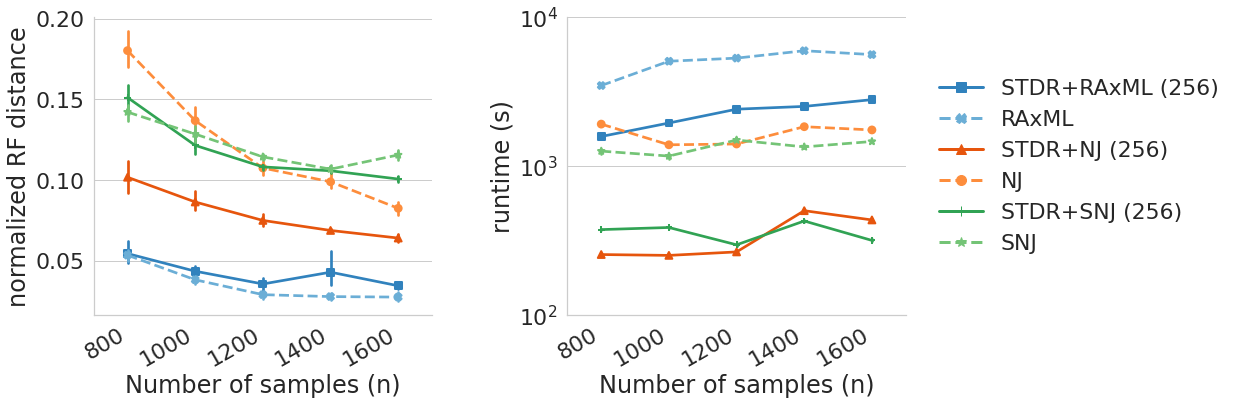

In [6]:
df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (256)", "RAxML", "STDR+NJ (256)","NJ",  "STDR+SNJ (256)", "SNJ"]
markers = ["s", "X", "^", "o", "+", "*"]
linestyles = ["-", "--", "-", "--", "-", "--"]


selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")

df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] 
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

# remove sample 400, 600
df_long = df_long.loc[~np.isin(df_long.m, [400, 600]),:]

color_subset = [colors[i] for i in [0,1,4,5,8,9]]
color_dict = dict(zip(ordering, np.array(color_subset)))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, 
                markers = markers, 
                linestyles= linestyles, legend = False,
                legend_out = True, gridspec_kws={"wspace":0.4})

labels = ["normalized RF distance", "runtime (s)"]

# adjust ticks and grid lines
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    if i == 1:
        ax.set(yscale="log")
        ax.set(ylim=(0, 8000))
        ax.set_yticks([10**2, 10**3, 10**4], minor = False)
        ax.set_yticks( [10**2.5, 10**3], minor = True)
        
    
g.set_titles("")
g.set_xlabels("Number of samples (n)")
plt.subplots_adjust(wspace = 0.4)

# adjust legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],  color=color_subset[x], marker = markers[x], markersize=10,linestyle = linestyles[x], lw = 3) for x in range(6)]

plt.legend(custom_lines, ordering, bbox_to_anchor=(1.04, 0.5), loc = "center left", frameon = False)
plt.savefig("birth_death_performance.eps", bbox_inches="tight")

## Random walk Laplacian

In [1]:
import glob
import pandas as pd
import re
from matplotlib import cm

def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        perf_metrics.loc[:,"RF"] = perf_metrics.loc[:,"RF"] / (2 * 2000 - 6)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/birthdeath_rw_m*")
metrics, summarized = summarize_perf(paths)
summarized

runtime           RF           F1      
                          mean    std  mean   std   mean   std
m    method                                                   
400  RAxML             2091.28  21.44  0.07  0.00  96.39  0.19
     STDR+RAxML (128)   869.78  16.61  0.09  0.00  95.72  0.25
     STDR+RAxML (256)  1077.59  20.52  0.09  0.01  95.37  0.41
     STDR+RAxML (64)    645.25   5.57  0.11  0.01  94.72  0.28
     STDR+NJ (64)       328.60   3.39  0.13  0.01  93.65  0.25
...                        ...    ...   ...   ...    ...   ...
1600 NJ                1975.92  43.96  0.09  0.00  95.75  0.07
     STDR+SNJ (256)     418.27  10.91  0.10  0.00  94.99  0.17
     STDR+SNJ (128)     436.27  12.45  0.10  0.00  95.09  0.25
     STDR+SNJ (64)      464.19  38.04  0.10  0.01  95.17  0.30
     SNJ               1479.93  18.47  0.11  0.00  94.57  0.14

[84 rows x 6 columns]

/home/mw957/project/conda_envs/r_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


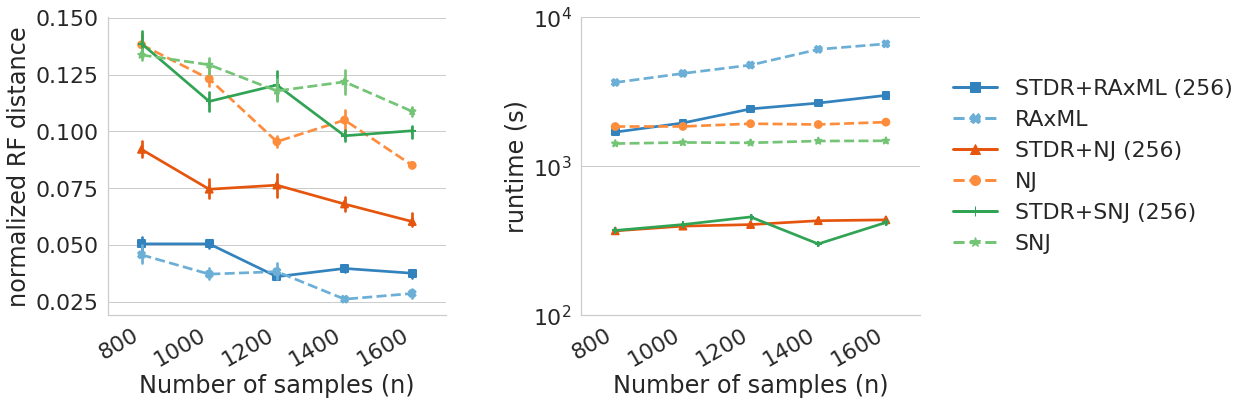

In [2]:
df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (256)", "RAxML", "STDR+NJ (256)","NJ",  "STDR+SNJ (256)", "SNJ"]
markers = ["s", "X", "^", "o", "+", "*"]
linestyles = ["-", "--", "-", "--", "-", "--"]


selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")

df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] 
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

# remove sample 400, 600
df_long = df_long.loc[~np.isin(df_long.m, [400, 600]),:]

color_subset = [colors[i] for i in [0,1,4,5,8,9]]
color_dict = dict(zip(ordering, np.array(color_subset)))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, 
                markers = markers, 
                linestyles= linestyles, legend = False,
                legend_out = True, gridspec_kws={"wspace":0.4})

labels = ["normalized RF distance", "runtime (s)"]

# adjust ticks and grid lines
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    if i == 1:
        ax.set(yscale="log")
        ax.set(ylim=(0, 8000))
        ax.set_yticks([10**2, 10**3, 10**4], minor = False)
        ax.set_yticks( [10**2.5, 10**3], minor = True)
        
    
g.set_titles("")
g.set_xlabels("Number of samples (n)")
plt.subplots_adjust(wspace = 0.4)

# adjust legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],  color=color_subset[x], marker = markers[x], markersize=10,linestyle = linestyles[x], lw = 3) for x in range(6)]

plt.legend(custom_lines, ordering, bbox_to_anchor=(1.04, 0.5), loc = "center left", frameon = False)
#plt.savefig("birth_death_performance.eps", bbox_inches="tight")

## global diff as merge method

In [1]:
import glob
import pandas as pd
import re
from matplotlib import cm

def summarize_perf(paths, agg = ["mean", "std"], sort_values = ["m", ('RF', 'mean'), ("runtime", "mean")], ascend = [True, True, True]):
    df = pd.DataFrame()
    for path in paths:
        perf_metrics = pd.read_csv(path)
        m = re.search('m([0-9]+)', path).group(1)
        perf_metrics = perf_metrics.loc[:, ["method", "threshold", "runtime", "RF", "F1"]]
        perf_metrics.loc[:,"m"] = int(m)
        perf_metrics.loc[:,"RF"] = perf_metrics.loc[:,"RF"] / (2 * 2000 - 6)
        has_threshold = (perf_metrics.threshold != 0) & (perf_metrics.threshold != "None")
        perf_metrics.loc[has_threshold,'method'] = perf_metrics.loc[has_threshold,'method'] + " (" + perf_metrics.loc[has_threshold,'threshold'].astype(float).astype(int).astype(str) + ")"
        perf_metrics = perf_metrics.loc[:, ["method", "m", "runtime", "RF", "F1"]]
        
        df = df.append(perf_metrics)
    perf_summarized = df.groupby(["m", "method"]).agg(agg).round(2).sort_values(sort_values, ascending=ascend)
    return df, perf_summarized

paths = glob.glob("/gpfs/ysm/project/kleinstein/mw957/repos/spectral-tree-inference/experiments/results/birthdeath_global_diff_m*")
metrics, summarized = summarize_perf(paths)
summarized

runtime           RF           F1      
                      mean    std  mean   std   mean   std
m    method                                               
400  STDR+NJ (256)  313.38   3.24  0.14  0.01  92.91  0.33
     STDR+NJ (128)  323.25   7.07  0.14  0.01  93.08  0.70
     STDR+NJ (64)   318.80   1.91  0.15  0.01  92.63  0.75
600  STDR+NJ (128)  337.40   2.66  0.11  0.00  94.43  0.13
     STDR+NJ (256)  369.55   9.62  0.11  0.01  94.38  0.68
     STDR+NJ (64)   360.86   7.04  0.14  0.03  92.82  1.28
800  STDR+NJ (256)  372.04   8.11  0.09  0.00  95.39  0.24
     STDR+NJ (128)  373.13  12.51  0.11  0.02  94.63  0.75
     STDR+NJ (64)   343.11   7.98  0.12  0.01  94.18  0.27
1000 STDR+NJ (128)  367.98   6.93  0.08  0.00  96.23  0.15
     STDR+NJ (256)  397.91   3.34  0.08  0.00  95.92  0.18
     STDR+NJ (64)   382.79   3.96  0.09  0.01  95.66  0.44
1200 STDR+NJ (128)  412.48   6.67  0.07  0.01  96.38  0.50
     STDR+NJ (256)  419.57  17.55  0.07  0.00  96.58  0.19
     STDR+NJ (64)   420.64  13.93  0.08  0.01  95.95  0.48
1400 STDR+NJ (64)   416.09  11.34  0.06  0.01  96.94  0.27
     STDR+NJ (128)  424.91   6.55  0.06  0.01  96.89  0.51
     STDR+NJ (256)  445.71  17.52  0.06  0.01  96.86  0.31
1600 STDR+NJ (256)  430.16  11.98  0.06  0.01  96.97  0.27
     STDR+NJ (64)   435.23  11.70  0.07  0.02  96.39  0.89
     STDR+NJ (128)  438.97  13.03  0.07  0.01  96.31  0.54

In [ ]:
df_long = pd.melt(metrics, id_vars = ["method", "m"], var_name = "performance").sort_values(["method", "performance"])

ordering = ["STDR+RAxML (256)", "STDR+RAxML (128)", "STDR+RAxML (64)", "RAxML", 
            "STDR+NJ (256)", "STDR+NJ (128)", "STDR+NJ (64)", "NJ", 
            "STDR+SNJ (256)", "STDR+SNJ (128)", "STDR+SNJ (64)", "SNJ"]
cmap = cm.get_cmap("tab20c", 20)
colors = [cmap(i) for i in range(12)]
color_dict = dict(zip(ordering, colors))


import numpy as np
ordering = [ "STDR+RAxML (256)", "RAxML", "STDR+NJ (256)","NJ",  "STDR+SNJ (256)", "SNJ"]
markers = ["s", "X", "^", "o", "+", "*"]
linestyles = ["-", "--", "-", "--", "-", "--"]


selected = np.isin(df_long.method, ordering) & (df_long.performance.values != "F1")

df_long = df_long.iloc[selected,:]
df_long.loc[df_long.performance == "RF","value"] = df_long.loc[df_long.performance == "RF","value"] 
df_long.loc[df_long.performance == "RF","performance"] = "RF distance"
df_long.loc[df_long.performance == "runtime","performance"] = "runtime (s)"

# remove sample 400, 600
df_long = df_long.loc[~np.isin(df_long.m, [400, 600]),:]

color_subset = [colors[i] for i in [0,1,4,5,8,9]]
color_dict = dict(zip(ordering, np.array(color_subset)))

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style = "whitegrid", font_scale = 2)
g = sns.catplot(data = df_long, x = "m", y = "value", hue = "method", hue_order = ordering,
           col = "performance", kind = "point", sharey = False, height = 6,  aspect = 1.1,
                palette = color_dict, margin_titles = False, sizes = 20, 
                markers = markers, 
                linestyles= linestyles, legend = False,
                legend_out = True, gridspec_kws={"wspace":0.4})

labels = ["normalized RF distance", "runtime (s)"]

# adjust ticks and grid lines
for i, ax in enumerate(g.axes.flat):
    ax.set_ylabel(labels[i])
    plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    if i == 1:
        ax.set(yscale="log")
        ax.set(ylim=(0, 8000))
        ax.set_yticks([10**2, 10**3, 10**4], minor = False)
        ax.set_yticks( [10**2.5, 10**3], minor = True)
        
    
g.set_titles("")
g.set_xlabels("Number of samples (n)")
plt.subplots_adjust(wspace = 0.4)

# adjust legend
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0],  color=color_subset[x], marker = markers[x], markersize=10,linestyle = linestyles[x], lw = 3) for x in range(6)]

plt.legend(custom_lines, ordering, bbox_to_anchor=(1.04, 0.5), loc = "center left", frameon = False)
#plt.savefig("birth_death_performance.eps", bbox_inches="tight")